# Testing
### Haushalte in Neubau-Wohnungen nach Bauperiode, Zimmerzahl, Eigentumsart, Haushalttyp und Quartier, seit 2006

Spezialdatensatz zum Webartikel «Kleinere Wohnungen für grössere Haushalte» vom 15.04.2021.


Datum: 15.03.2022

### Importiere die notwendigen Packages

In [18]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [19]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import seaborn as sns


import requests
import io

In [20]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [21]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [22]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [23]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [24]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 3 datenstand:  1 time.struct_time(tm_year=2022, tm_mon=3, tm_mday=15, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=74, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [25]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [26]:
package_name = "bau_neubau_whg_hh_whnfl_bp_zizahl_eart_hhtyp_quart_od6991"

In [27]:
dataset_name = "BAU699OD6991.csv"

**Statische Pfade in DWH-Dropzones**

In [28]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [29]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [30]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [31]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [32]:
from IPython.display import Markdown as md

In [33]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_neubau_whg_hh_whnfl_bp_zizahl_eart_hhtyp_quart_od6991 

In [34]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_hh_whnfl_bp_zizahl_eart_hhtyp_quart_od6991 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [35]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

integ - web


In [36]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_neubau_whg_hh_whnfl_bp_zizahl_eart_hhtyp_quart_od6991/download/BAU699OD6991.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [42]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        #,parse_dates=['Jahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        #,parse_dates=['Jahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes
#data2betested.head()

web


Bauperiode      object
QuarSort         int64
QuarLang        object
KreisSort        int64
KreisLang       object
Zimmer          object
EigGruSort       int64
EigGruLang      object
Mietwohnung     object
HhGruppeSort     int64
HhGruppeLang    object
AnzWhg           int64
Wohnflaeche      int64
AnzPersonen      int64
AnzRentner       int64
AnzKinder        int64
dtype: object

Berechne weitere Attribute falls notwendig

In [44]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        #StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
    )
    #.sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

Bauperiode      object
QuarSort         int64
QuarLang        object
KreisSort        int64
KreisLang       object
Zimmer          object
EigGruSort       int64
EigGruLang      object
Mietwohnung     object
HhGruppeSort     int64
HhGruppeLang    object
AnzWhg           int64
Wohnflaeche      int64
AnzPersonen      int64
AnzRentner       int64
AnzKinder        int64
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [45]:
#data2betested.head(6)

In [49]:
#data2betested.dtypes

In [47]:
data2betested.shape

(5108, 16)

Beschreibe einzelne Attribute

In [50]:
data2betested.describe()

,QuarSort,KreisSort,EigGruSort,HhGruppeSort,AnzWhg,Wohnflaeche,AnzPersonen,AnzRentner,AnzKinder
count,5108,5108,5108,5108,5108,5108,5108,5108,5108
mean,78,8,3,4,6,544,13,1,3
std,33,3,1,3,13,1149,28,4,9
min,12,1,1,1,1,17,1,0,0
25%,52,5,2,2,1,120,2,0,0
50%,83,8,3,4,2,213,4,0,0
75%,111,11,5,6,5,492,12,0,2
max,123,12,5,9,310,23306,488,99,172


Wie viele Nullwerte gibt es im Datensatz?

In [51]:
data2betested.isnull().sum()

Bauperiode      0
QuarSort        0
QuarLang        0
KreisSort       0
KreisLang       0
Zimmer          0
EigGruSort      0
EigGruLang      0
Mietwohnung     0
HhGruppeSort    0
HhGruppeLang    0
AnzWhg          0
Wohnflaeche     0
AnzPersonen     0
AnzRentner      0
AnzKinder       0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [52]:
#data2betested = data2betested.set_index("StichtagDatJahr")

In [54]:
data2betested.info()
#data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5108 entries, 0 to 5107
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Bauperiode    5108 non-null   object
 1   QuarSort      5108 non-null   int64 
 2   QuarLang      5108 non-null   object
 3   KreisSort     5108 non-null   int64 
 4   KreisLang     5108 non-null   object
 5   Zimmer        5108 non-null   object
 6   EigGruSort    5108 non-null   int64 
 7   EigGruLang    5108 non-null   object
 8   Mietwohnung   5108 non-null   object
 9   HhGruppeSort  5108 non-null   int64 
 10  HhGruppeLang  5108 non-null   object
 11  AnzWhg        5108 non-null   int64 
 12  Wohnflaeche   5108 non-null   int64 
 13  AnzPersonen   5108 non-null   int64 
 14  AnzRentner    5108 non-null   int64 
 15  AnzKinder     5108 non-null   int64 
dtypes: int64(9), object(7)
memory usage: 638.6+ KB


### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [58]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [59]:
#data2betested.loc["2008":"2021"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

### Visualisierungen nach Zeitausschnitten

#### Entwicklung 

In [57]:
data2betested.columns

Index(['Bauperiode', 'QuarSort', 'QuarLang', 'KreisSort', 'KreisLang', 'Zimmer', 'EigGruSort',
       'EigGruLang', 'Mietwohnung', 'HhGruppeSort', 'HhGruppeLang', 'AnzWhg', 'Wohnflaeche',
       'AnzPersonen', 'AnzRentner', 'AnzKinder'],
      dtype='object')

In [63]:
myAgg = data2betested\
    .groupby(['Bauperiode', 'HhGruppeSort', 'HhGruppeLang']) \
    .agg(sum_AnzWhg=('AnzWhg', 'sum')
         , sum_Wohnflaeche=('Wohnflaeche', 'sum')
         , sum_AnzPersonen=('AnzPersonen', 'sum')
         , sum_AnzRentner=('AnzRentner', 'sum')
         , sum_AnzKinder=('AnzKinder', 'sum')
        ) \
    .sort_values('HhGruppeSort', ascending=True) 

myAgg.reset_index().head(3)

,Bauperiode,HhGruppeSort,HhGruppeLang,sum_AnzWhg,sum_Wohnflaeche,sum_AnzPersonen,sum_AnzRentner,sum_AnzKinder
0,2007–2011,1,1 Person im Erwerbsalter,1631,143097,1631,0,6
1,2017–2021,1,1 Person im Erwerbsalter,3028,202862,3028,0,0
2,2012–2016,1,1 Person im Erwerbsalter,2711,210237,2711,0,2


In [74]:
myTitle="Titel"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['HhGruppeSort'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index(), title=myTitle).encode(
    x=alt.X('HhGruppeSort', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzWhg', axis=alt.Axis(title='Anz. Projektierte Gebäude'))
    , color=alt.Color('Bauperiode', legend=alt.Legend(title="Projektstatus", orient="right"))  
    ,tooltip=['Bauperiode', 'HhGruppeSort', 'HhGruppeLang','sum_AnzPersonen']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [75]:
data2betested.columns

Index(['Bauperiode', 'QuarSort', 'QuarLang', 'KreisSort', 'KreisLang', 'Zimmer', 'EigGruSort',
       'EigGruLang', 'Mietwohnung', 'HhGruppeSort', 'HhGruppeLang', 'AnzWhg', 'Wohnflaeche',
       'AnzPersonen', 'AnzRentner', 'AnzKinder'],
      dtype='object')

In [83]:
myAggBar = data2betested\
    .groupby(['Bauperiode', 'Mietwohnung', 'HhGruppeSort', 'HhGruppeLang']) \
    .agg(sum_AnzWhg=('AnzWhg', 'sum')
         , sum_Wohnflaeche=('Wohnflaeche', 'sum')
         , sum_AnzPersonen=('AnzPersonen', 'sum')
         , sum_AnzRentner=('AnzRentner', 'sum')
         , sum_AnzKinder=('AnzKinder', 'sum')
        ) \
    .sort_values('HhGruppeSort', ascending=True) 

myAggBar.reset_index().head(3)

,Bauperiode,Mietwohnung,HhGruppeSort,HhGruppeLang,sum_AnzWhg,sum_Wohnflaeche,sum_AnzPersonen,sum_AnzRentner,sum_AnzKinder
0,2007–2011,Ja,1,1 Person im Erwerbsalter,1332,108742,1332,0,5
1,2017–2021,Nein,1,1 Person im Erwerbsalter,153,14570,153,0,0
2,2017–2021,Ja,1,1 Person im Erwerbsalter,2875,188292,2875,0,0


In [84]:
#help(sns.catplot)     

In [85]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

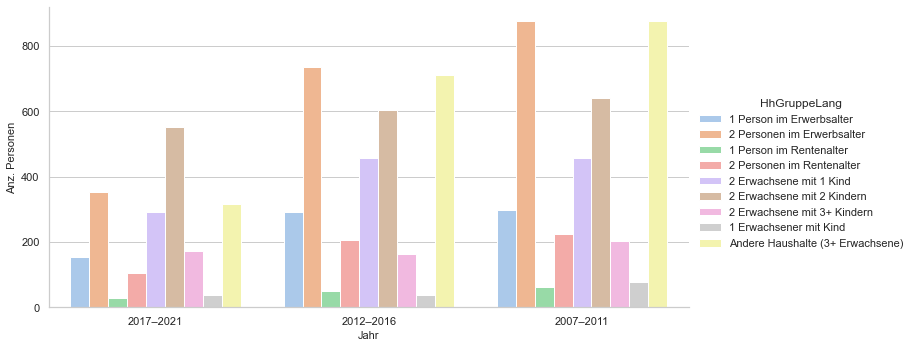

In [91]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Bauperiode"
            , y="sum_AnzPersonen"
            , hue="HhGruppeLang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.query('Mietwohnung == "Nein"').sort_values('HhGruppeSort', ascending=True).reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Personen', fontsize=11)


In [92]:
data2betested.columns

Index(['Bauperiode', 'QuarSort', 'QuarLang', 'KreisSort', 'KreisLang', 'Zimmer', 'EigGruSort',
       'EigGruLang', 'Mietwohnung', 'HhGruppeSort', 'HhGruppeLang', 'AnzWhg', 'Wohnflaeche',
       'AnzPersonen', 'AnzRentner', 'AnzKinder'],
      dtype='object')

In [106]:
myAggBar = data2betested\
    .groupby(['KreisSort', 'KreisLang', 'Zimmer']) \
    .agg(sum_AnzWhg=('AnzWhg', 'sum')
         , sum_Wohnflaeche=('Wohnflaeche', 'sum')
         , sum_AnzPersonen=('AnzPersonen', 'sum')
         , sum_AnzRentner=('AnzRentner', 'sum')
         , sum_AnzKinder=('AnzKinder', 'sum')
        ) \
    .sort_values('KreisSort', ascending=True) 

myAggBar.reset_index().head(3)

,KreisSort,KreisLang,Zimmer,sum_AnzWhg,sum_Wohnflaeche,sum_AnzPersonen,sum_AnzRentner,sum_AnzKinder
0,1,Kreis 1,3 Zimmer,2,198,6,0,3
1,1,Kreis 1,4 Zimmer,3,368,7,0,1
2,2,Kreis 2,1 Zimmer,51,3063,74,7,8


In [107]:
#myAggBar.reset_index()

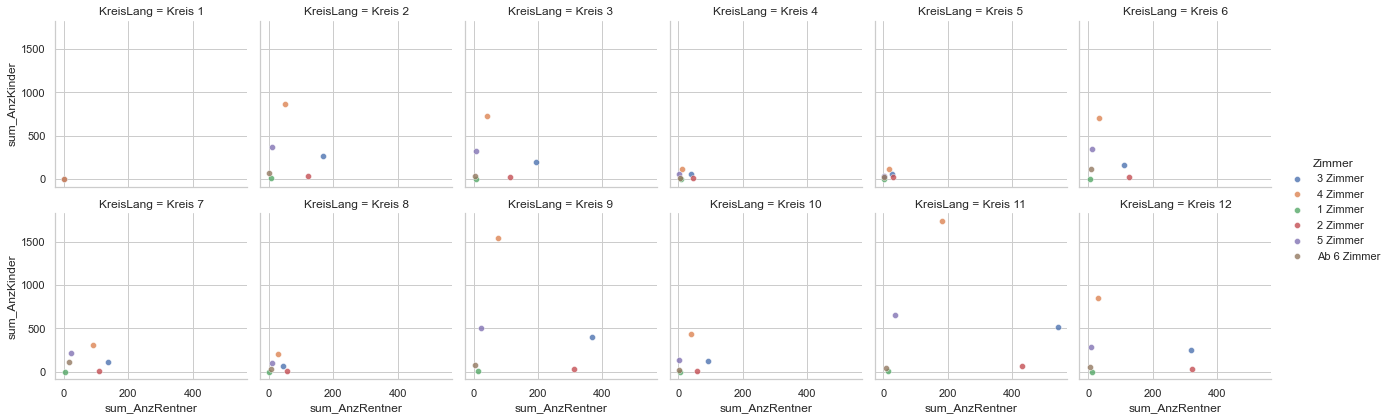

In [110]:
g = sns.FacetGrid(myAggBar.sort_values('KreisSort', ascending=True).reset_index(), col="KreisLang", hue="Zimmer", col_wrap=6, height=3,)
g.map(sns.scatterplot, "sum_AnzRentner", "sum_AnzKinder", alpha=.8)
#g.map(sns.lineplot, "Zimmer","sum_AnzPersonen",alpha=.8)

g.add_legend()

## ---------------------- hier Plausi beendet ---------------------- 

**Sharepoint als gecheckt markieren!**


Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=879&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------- 